# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups               
Sample_134  A0A087WX80;P24043               16.534
Sample_116  A9UJN9;A9UJP0;P01127;P01127-2   19.121
Sample_010  P22004                          13.700
Sample_133  O43505                          23.399
Sample_065  P23471;P23471-2                 20.308
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups                   
Sample_146  P15144                              15.149
Sample_084  H0Y7C8;O14657                       10.321
Sample_173  Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4   16.486
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.855
            A0A075B6Q5                 12.847
            A0A075B6R2                 13.619
            A0A075B6S5                 12.009
            A0A087WSY4                 14.502
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.595
            Q9UI40;Q9UI40-2            11.827
            Q9UIW2                     12.606
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.714
            Q9UP79                     11.855
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.062,15.050,16.842,19.863,15.971,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.762,19.067,...,15.528,15.576,14.024,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.964,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.541,17.705,17.039,15.852,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.979,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.858,15.345,17.084,18.708,14.249,19.433,11.677,10.788
Sample_207,15.739,16.877,15.469,16.898,13.269,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.337,12.875,13.478,13.099,12.800,13.330,13.162,13.375,13.473,14.113
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.000,19.067,16.127,...,11.359,12.790,12.791,12.384,12.945,12.345,12.820,12.909,12.343,12.745
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.511,12.728,13.137,13.151,13.399,12.974,11.465,13.133,12.425,12.532
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,10.521,12.632,14.061,12.467,11.296,12.997,13.686,12.471,14.749,13.032
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.770,13.435,12.245,12.464,12.408,11.085,12.354,13.670,12.816,13.418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.089,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 324.74it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.76it/s]

100%|██████████| 3/3 [00:00<00:00,  5.53it/s]

100%|██████████| 3/3 [00:00<00:00,  5.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.26it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.90it/s]

100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

100%|██████████| 4/4 [00:00<00:00,  4.94it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.98it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.76it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.76it/s]

100%|██████████| 5/5 [00:00<00:00,  4.53it/s]

100%|██████████| 5/5 [00:00<00:00,  5.02it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.47it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.87it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.21it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.99it/s]

100%|██████████| 6/6 [00:01<00:00,  4.12it/s]

100%|██████████| 6/6 [00:01<00:00,  4.34it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.48it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.21it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.28it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.84it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.70it/s]

100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.91it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.70it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.82it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.36it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.95it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.74it/s]

100%|██████████| 8/8 [00:01<00:00,  3.67it/s]

100%|██████████| 8/8 [00:01<00:00,  4.18it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.14it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.65it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.64it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.25it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.21it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.17it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.88it/s]

100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

100%|██████████| 9/9 [00:02<00:00,  4.16it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.62it/s]

 30%|███       | 3/10 [00:00<00:01,  4.68it/s]

 40%|████      | 4/10 [00:00<00:01,  4.38it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.01it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.90it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.91it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.88it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.70it/s]

100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.52it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.06it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.84it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.39it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.04it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.92it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.60it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.68it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.67it/s]

100%|██████████| 11/11 [00:02<00:00,  3.66it/s]

100%|██████████| 11/11 [00:02<00:00,  4.05it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.27it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.52it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.12it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.75it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.58it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.51it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.17it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.01it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.02it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.00it/s]

100%|██████████| 12/12 [00:02<00:00,  3.89it/s]

100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.19it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.72it/s]

 31%|███       | 4/13 [00:01<00:02,  3.28it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.87it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.79it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.65it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.56it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.46it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.42it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.35it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.58it/s]

100%|██████████| 13/13 [00:04<00:00,  2.78it/s]

100%|██████████| 13/13 [00:04<00:00,  2.77it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.53it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.63it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.61it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.13it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.95it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.88it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.97it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.97it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.76it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.89it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.71it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.36it/s]

100%|██████████| 14/14 [00:03<00:00,  2.87it/s]

100%|██████████| 14/14 [00:03<00:00,  3.70it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.80it/s]

 20%|██        | 3/15 [00:00<00:03,  3.18it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.85it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.79it/s]

 40%|████      | 6/15 [00:01<00:03,  2.95it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.96it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.28it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.29it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.51it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.48it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.47it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.57it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.61it/s]

100%|██████████| 15/15 [00:04<00:00,  3.69it/s]

100%|██████████| 15/15 [00:04<00:00,  3.37it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.037 0.006          0.756 0.355       0.114   
2             0.003 0.000      0.039 0.012          0.753 0.079       0.701   
3             0.003 0.002      0.038 0.011          0.746 0.084       0.697   
4             0.004 0.002      0.039 0.012          0.760 0.081       0.722   
5             0.003 0.000      0.036 0.001          0.783 0.079       0.768   
6             0.004 0.002      0.037 0.006          0.786 0.085       0.771   
7             0.004 0.000      0.036 0.003          0.778 0.085       0.763   
8             0.003 0.000      0.036 0.001          0.813 0.079       0.809   
9             0.004 0.000      0.035 0.002          0.818 0.078       0.806   
10            0.003 0.002      0.029 0.004          0.815 0.079       0.809   
11            0.004 0.002      0.038 0.014          0.814 0.082       0.805   
12            0.003 0.001      0.031 0.004          0.808 0.078       0.801   
13            0.004 0.002      0.037 0.007          0.806 0.080       0.795   
14            0.005 0.004      0.047 0.016          0.803 0.084       0.794   
15            0.004 0.003      0.042 0.013          0.793 0.084       0.782   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.191 0.130                  0.550 0.042        0.856   
2          0.119   0.720 0.082                  0.766 0.062        0.859   
3          0.108   0.715 0.076                  0.760 0.059        0.855   
4          0.105   0.735 0.074                  0.776 0.058        0.857   
5          0.094   0.772 0.067                  0.805 0.056        0.870   
6          0.094   0.774 0.068                  0.807 0.056        0.901   
7          0.102   0.766 0.075                  0.801 0.060        0.898   
8          0.096   0.807 0.068                  0.835 0.058        0.908   
9          0.095   0.809 0.069                  0.837 0.059        0.908   
10         0.099   0.808 0.070                  0.836 0.060        0.907   
11         0.100   0.806 0.072                  0.834 0.061        0.905   
12         0.103   0.800 0.072                  0.830 0.060        0.906   
13         0.106   0.796 0.074                  0.827 0.062        0.906   
14         0.106   0.794 0.075                  0.825 0.064        0.905   
15         0.099   0.783 0.071                  0.815 0.060        0.902   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.825 0.091        210.000 0.000  
2          0.053                  0.834 0.065        210.000 0.000  
3          0.051                  0.829 0.062        210.000 0.000  
4          0.047                  0.829 0.058        210.000 0.000  
5          0.051                  0.839 0.067        210.000 0.000  
6          0.048                  0.878 0.057        210.000 0.000  
7          0.048                  0.873 0.059        210.000 0.000  
8          0.048                  0.891 0.052        210.000 0.000  
9          0.048                  0.891 0.051        210.000 0.000  
10         0.049                  0.890 0.053        210.000 0.000  
11         0.049                  0.887 0.054        210.000 0.000  
12         0.049                  0.891 0.053        210.000 0.000  
13         0.049                  0.891 0.053        210.000 0.000  
14         0.051                  0.890 0.054        210.000 0.000  
15         0.050                  0.885 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 526.53it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.18it/s]

100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.61it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.97it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.86it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.75it/s]

100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.90it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.97it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.22it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.98it/s]

100%|██████████| 6/6 [00:01<00:00,  2.79it/s]

100%|██████████| 6/6 [00:01<00:00,  3.14it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.60it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.78it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.12it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.83it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.01it/s]

100%|██████████| 7/7 [00:02<00:00,  2.91it/s]

100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.83it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.32it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.80it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.63it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.46it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.98it/s]

100%|██████████| 8/8 [00:02<00:00,  2.81it/s]

100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.54it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.01it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.56it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.06it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.74it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.76it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.56it/s]

100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

100%|██████████| 9/9 [00:02<00:00,  3.68it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.86it/s]

 30%|███       | 3/10 [00:00<00:01,  4.37it/s]

 40%|████      | 4/10 [00:00<00:01,  4.01it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.96it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.50it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.47it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.42it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.54it/s]

100%|██████████| 10/10 [00:02<00:00,  3.13it/s]

100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.23it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.69it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.07it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.78it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.57it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.57it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.37it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.42it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.52it/s]

100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

100%|██████████| 11/11 [00:03<00:00,  3.59it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.47it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.33it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.94it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.55it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.43it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.31it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.20it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.25it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.34it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.41it/s]

100%|██████████| 12/12 [00:03<00:00,  3.42it/s]

100%|██████████| 12/12 [00:03<00:00,  3.52it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.38it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.05it/s]

 31%|███       | 4/13 [00:01<00:03,  2.51it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.49it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.49it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.64it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.72it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.86it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.80it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.00it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  3.18it/s]

100%|██████████| 13/13 [00:04<00:00,  3.28it/s]

100%|██████████| 13/13 [00:04<00:00,  2.93it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.57it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.56it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.78it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.56it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.35it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.86it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.54it/s]

 64%|██████▍   | 9/14 [00:02<00:02,  2.50it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.46it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.38it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.52it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.57it/s]

100%|██████████| 14/14 [00:04<00:00,  2.75it/s]

100%|██████████| 14/14 [00:04<00:00,  2.88it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.30it/s]

 20%|██        | 3/15 [00:00<00:03,  3.90it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.37it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.09it/s]

 40%|████      | 6/15 [00:01<00:02,  3.09it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.12it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.06it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.02it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.03it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.14it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.19it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.12it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.25it/s]

100%|██████████| 15/15 [00:04<00:00,  3.36it/s]

100%|██████████| 15/15 [00:04<00:00,  3.26it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.050 0.021          0.120 0.291       0.014   
2             0.004 0.004      0.045 0.023          0.723 0.092       0.619   
3             0.003 0.000      0.041 0.015          0.799 0.102       0.731   
4             0.003 0.000      0.039 0.010          0.802 0.100       0.715   
5             0.004 0.002      0.045 0.014          0.795 0.105       0.743   
6             0.004 0.003      0.047 0.018          0.789 0.108       0.737   
7             0.006 0.005      0.054 0.021          0.782 0.108       0.730   
8             0.005 0.006      0.053 0.021          0.808 0.091       0.767   
9             0.006 0.004      0.059 0.025          0.797 0.094       0.759   
10            0.006 0.005      0.058 0.021          0.803 0.083       0.757   
11            0.005 0.004      0.050 0.019          0.806 0.085       0.774   
12            0.006 0.004      0.058 0.021          0.797 0.083       0.772   
13            0.006 0.005      0.052 0.019          0.806 0.083       0.789   
14            0.004 0.002      0.038 0.008          0.829 0.078       0.787   
15            0.004 0.000      0.048 0.018          0.826 0.081       0.777   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.039   0.024 0.064                  0.503 0.017        0.868   
2          0.111   0.660 0.086                  0.721 0.060        0.826   
3          0.113   0.756 0.076                  0.795 0.060        0.901   
4          0.123   0.748 0.088                  0.790 0.067        0.897   
5          0.124   0.761 0.086                  0.798 0.071        0.898   
6          0.120   0.755 0.085                  0.793 0.069        0.896   
7          0.126   0.747 0.089                  0.787 0.073        0.895   
8          0.116   0.781 0.080                  0.815 0.065        0.908   
9          0.116   0.772 0.080                  0.807 0.066        0.907   
10         0.116   0.774 0.079                  0.810 0.064        0.917   
11         0.113   0.785 0.080                  0.818 0.066        0.920   
12         0.111   0.780 0.078                  0.813 0.066        0.920   
13         0.107   0.792 0.073                  0.824 0.061        0.920   
14         0.101   0.803 0.067                  0.832 0.056        0.925   
15         0.106   0.795 0.070                  0.827 0.058        0.922   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.833 0.085        210.000 0.000  
2          0.059                  0.784 0.074        210.000 0.000  
3          0.046                  0.878 0.064        210.000 0.000  
4          0.046                  0.876 0.060        210.000 0.000  
5          0.047                  0.879 0.060        210.000 0.000  
6          0.049                  0.876 0.062        210.000 0.000  
7          0.049                  0.875 0.062        210.000 0.000  
8          0.047                  0.889 0.059        210.000 0.000  
9          0.049                  0.890 0.060        210.000 0.000  
10         0.045                  0.904 0.053        210.000 0.000  
11         0.043                  0.907 0.051        210.000 0.000  
12         0.043                  0.906 0.049        210.000 0.000  
13         0.043                  0.908 0.049        210.000 0.000  
14         0.041                  0.914 0.045        210.000 0.000  
15         0.041                  0.910 0.046 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1111.37it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 24.32it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 23.52it/s]

100%|██████████| 3/3 [00:00<00:00, 23.38it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.94it/s]

100%|██████████| 4/4 [00:00<00:00, 15.40it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 15.21it/s]

100%|██████████| 5/5 [00:00<00:00, 16.99it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 17.77it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 11.95it/s]

100%|██████████| 6/6 [00:00<00:00, 12.32it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 15.31it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 12.84it/s]

100%|██████████| 7/7 [00:00<00:00, 12.65it/s]

100%|██████████| 7/7 [00:00<00:00, 12.70it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.10it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.13it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 11.36it/s]

100%|██████████| 8/8 [00:00<00:00, 12.18it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 27.75it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 16.45it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 14.91it/s]

100%|██████████| 9/9 [00:00<00:00, 15.76it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 16.89it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.44it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.59it/s]

 90%|█████████ | 9/10 [00:00<00:00, 13.68it/s]

100%|██████████| 10/10 [00:00<00:00, 13.63it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.40it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.50it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 15.38it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 14.56it/s]

100%|██████████| 11/11 [00:00<00:00, 14.40it/s]

100%|██████████| 11/11 [00:00<00:00, 14.93it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.07it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.53it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.36it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.56it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 11.95it/s]

100%|██████████| 12/12 [00:00<00:00, 12.20it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 22.76it/s]

 46%|████▌     | 6/13 [00:00<00:00, 17.12it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 16.17it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.09it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.77it/s]

100%|██████████| 13/13 [00:00<00:00, 14.97it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 15.79it/s]

 36%|███▌      | 5/14 [00:00<00:00, 14.33it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.40it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.38it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.77it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 13.13it/s]

100%|██████████| 14/14 [00:01<00:00, 13.30it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 23.92it/s]

 40%|████      | 6/15 [00:00<00:00, 15.37it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 14.56it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 14.85it/s]

 80%|████████  | 12/15 [00:00<00:00, 14.07it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 13.40it/s]

100%|██████████| 15/15 [00:01<00:00, 13.77it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.037 0.009          0.000 0.000       0.000   
2             0.005 0.004      0.046 0.015          0.697 0.086       0.532   
3             0.003 0.000      0.032 0.003          0.691 0.088       0.555   
4             0.005 0.004      0.051 0.024          0.696 0.084       0.588   
5             0.003 0.000      0.037 0.007          0.693 0.087       0.589   
6             0.006 0.006      0.063 0.026          0.683 0.088       0.577   
7             0.005 0.004      0.045 0.018          0.677 0.096       0.563   
8             0.006 0.005      0.059 0.024          0.681 0.092       0.621   
9             0.006 0.005      0.065 0.025          0.683 0.095       0.625   
10            0.006 0.005      0.054 0.021          0.657 0.081       0.625   
11            0.005 0.003      0.042 0.013          0.641 0.079       0.615   
12            0.005 0.005      0.052 0.027          0.631 0.078       0.602   
13            0.006 0.006      0.053 0.021          0.651 0.083       0.655   
14            0.006 0.007      0.061 0.028          0.636 0.074       0.632   
15            0.006 0.005      0.048 0.015          0.633 0.079       0.625   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.729   
2          0.109   0.596 0.081                  0.679 0.053        0.791   
3          0.104   0.609 0.076                  0.684 0.056        0.781   
4          0.114   0.631 0.085                  0.699 0.060        0.780   
5          0.118   0.630 0.086                  0.698 0.061        0.775   
6          0.118   0.618 0.088                  0.689 0.062        0.772   
7          0.120   0.606 0.085                  0.681 0.062        0.768   
8          0.116   0.643 0.089                  0.702 0.069        0.807   
9          0.114   0.647 0.089                  0.705 0.070        0.802   
10         0.111   0.636 0.081                  0.693 0.064        0.802   
11         0.109   0.622 0.078                  0.681 0.062        0.800   
12         0.106   0.611 0.077                  0.672 0.060        0.797   
13         0.115   0.648 0.085                  0.699 0.070        0.809   
14         0.114   0.629 0.078                  0.684 0.060        0.810   
15         0.123   0.623 0.084                  0.680 0.066        0.807   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.070                  0.682 0.078        210.000 0.000  
2          0.069                  0.709 0.080        210.000 0.000  
3          0.067                  0.703 0.079        210.000 0.000  
4          0.064                  0.706 0.077        210.000 0.000  
5          0.066                  0.698 0.076        210.000 0.000  
6          0.065                  0.694 0.075        210.000 0.000  
7          0.071                  0.694 0.078        210.000 0.000  
8          0.062                  0.750 0.077        210.000 0.000  
9          0.064                  0.745 0.078        210.000 0.000  
10         0.064                  0.749 0.074        210.000 0.000  
11         0.063                  0.755 0.072        210.000 0.000  
12         0.062                  0.751 0.070        210.000 0.000  
13         0.062                  0.758 0.075        210.000 0.000  
14         0.057                  0.765 0.066        210.000 0.000  
15         0.057                  0.759 0.068 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,7,14
score_time,14,9,9
test_precision,9,14,2
test_recall,8,13,13
test_f1,9,14,13
test_balanced_accuracy,9,14,9
test_roc_auc,8,14,14
test_average_precision,12,14,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.55it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.81it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.60it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.61it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.72it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.83it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.90it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.90it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.91it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.96it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  3.00it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.04it/s]

100%|██████████| 14/14 [00:04<00:00,  3.06it/s]

100%|██████████| 14/14 [00:04<00:00,  2.92it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 18.24it/s]

 29%|██▊       | 4/14 [00:00<00:00, 12.80it/s]

 43%|████▎     | 6/14 [00:00<00:00, 12.33it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 10.97it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 10.34it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  9.87it/s]

100%|██████████| 14/14 [00:01<00:00,  9.86it/s]

100%|██████████| 14/14 [00:01<00:00, 10.57it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.51it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.37it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.75it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.72it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.77it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.77it/s]

100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


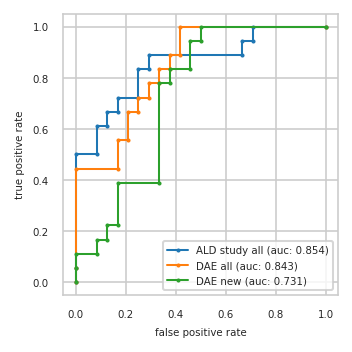

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.500   0.000 0.444   0.000 0.111
3          0.083 0.500   0.167 0.444   0.083 0.111
4          0.083 0.611   0.167 0.556   0.083 0.167
5          0.125 0.611   0.208 0.556   0.125 0.167
6          0.125 0.667   0.208 0.667   0.125 0.222
7          0.167 0.667   0.250 0.667   0.167 0.222
8          0.167 0.722   0.250 0.722   0.167 0.389
9          0.250 0.722   0.292 0.722   0.333 0.389
10         0.250 0.833   0.292 0.778   0.333 0.778
11         0.292 0.833   0.333 0.778   0.375 0.778
12         0.292 0.889   0.333 0.833   0.375 0.833
13         0.667 0.889   0.375 0.833   0.458 0.833
14         0.667 0.944   0.375 0.889   0.458 0.944
15         0.708 0.944   0.417 0.889   0.500 0.944
16         0.708 1.000   0.417 1.000   0.500 1.000
17         1.000 1.000   1.000 1.000   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q9NX62,Q13444;Q13444-10;Q13444-11;Q13444-12;Q13444-2;...,P01704
2,P04114,P08670,P51688
3,P61981,Q14894,P42262;P42262-2;P42262-3
4,P14174,Q9Y2T3;Q9Y2T3-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P04075,A0A0A0MRJ7;P12259,P31321
6,Q9Y2T3;Q9Y2T3-3,P61981,E9PK25;G3V1A4;P23528
7,P00338;P00338-3,P04075,Q8TEA8
8,None,P14174,A0A0C4DGV4;E9PLX3;O43504;R4GMU8


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


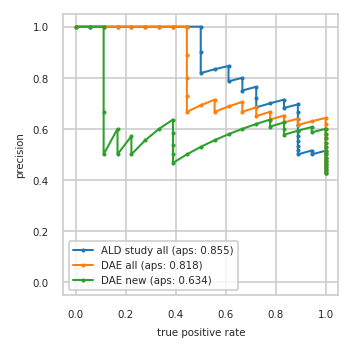

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.529 1.000
9          0.515 0.944     0.545 1.000     0.545 1.000
10         0.500 0.889     0.562 1.000     0.562 1.000
11         0.516 0.889     0.581 1.000     0.581 1.000
12         0.533 0.889     0.600 1.000     0.600 1.000
13         0.552 0.889     0.621 1.000     0.586 0.944
14         0.571 0.889     0.643 1.000     0.607 0.944
15         0.593 0.889     0.630 0.944     0.593 0.889
16         0.615 0.889     0.615 0.889     0.577 0.833
17         0.640 0.889     0.640 0.889     0.600 0.833
18         0.667 0.889     0.625 0.833     0.625 0.833
19         0.696 0.889     0.652 0.833     0.609 0.778
20         0.682 0.833     0.636 0.778     0.636 0.778
21         0.714 0.833     0.667 0.778     0.619 0.722
22         0.700 0.778     0.650 0.722     0.600 0.667
23         0.684 0.722     0.684 0.722     0.579 0.611
24         0.722 0.722     0.667 0.667     0.556 0.556
25         0.765 0.722     0.706 0.667     0.529 0.500
26         0.750 0.667     0.688 0.611     0.500 0.444
27         0.800 0.667     0.667 0.556     0.467 0.389
28         0.786 0.611     0.714 0.556     0.500 0.389
29         0.846 0.611     0.692 0.500     0.538 0.389
30         0.833 0.556     0.667 0.444     0.583 0.389
31         0.818 0.500     0.727 0.444     0.636 0.389
32         0.900 0.500     0.800 0.444     0.600 0.333
33         1.000 0.500     0.889 0.444     0.556 0.278
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


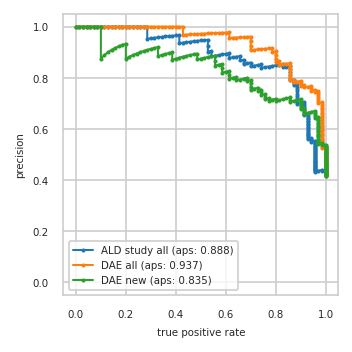

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


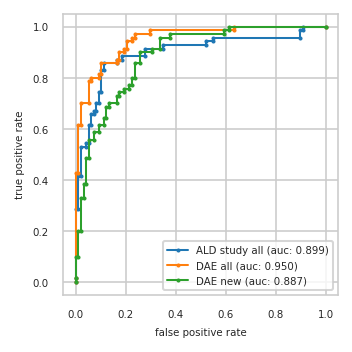

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}